# Análisis de ítems cerrados

## Montar Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Ruta de ficheros CSV a procesar
ruta_trabajo="/content/gdrive/MyDrive/sochedi2025/"

In [4]:
import pandas as pd

# Cargar CSV
df = pd.read_csv(ruta_trabajo + "dataset_survey_anonymized_v2.csv")

# Revisar primeras filas
print(df.head())

   semestre           p01  p03  p04  p05  p06  p07  p08  p09  p10  ...  p55  \
0    202410  05_Excelente    5    5    5    5    5    5    5    5  ...    5   
1    202410    03_Neutral    4    4    3    4    3    5    4    3  ...    4   
2    202410  04_Muy bueno    5    5    5    5    5    5    5    5  ...    5   
3    202410    03_Neutral    2    2    3    5    5    3    4    5  ...    3   
4    202410  05_Excelente    5    5    5    5    5    5    5    5  ...    5   

           p56               p57              p58          p59  p60  p61  p62  \
0  Algo pesada    Algo más fácil       Algo largo      Similar    1    1    1   
1  Algo pesada  Algo más difícil       Algo largo        Mejor    1    0    0   
2  Algo pesada           Similar        Apropiado        Mejor    0    1    0   
3    Apropiada  Algo más difícil       Algo largo         Peor    0    0    1   
4  Algo pesada    Algo más fácil  Demasiado largo  Mucho mejor    0    1    1   

   p63                                

In [5]:
# Resumen de la variable p01 sin NaN
tabla_p01 = df['p01'].dropna().value_counts().reset_index()
tabla_p01.columns = ['Respuesta', 'Frecuencia']
tabla_p01['Porcentaje'] = (tabla_p01['Frecuencia'] / tabla_p01['Frecuencia'].sum() * 100).round(1)

# Ordenar las categorías de mejor a peor (opcional)
orden = ["05_Excelente", "04_Muy bueno", "03_Neutral", "02_No muy bueno", "01_Deficiente"]
tabla_p01['Respuesta'] = pd.Categorical(tabla_p01['Respuesta'], categories=orden, ordered=True)
tabla_p01 = tabla_p01.sort_values('Respuesta')

# Mostrar tabla en Colab
from IPython.display import display
display(tabla_p01)








,Respuesta,Frecuencia,Porcentaje
1,05_Excelente,41,24.7
0,04_Muy bueno,83,50.0
2,03_Neutral,35,21.1
4,02_No muy bueno,2,1.2
3,01_Deficiente,5,3.0


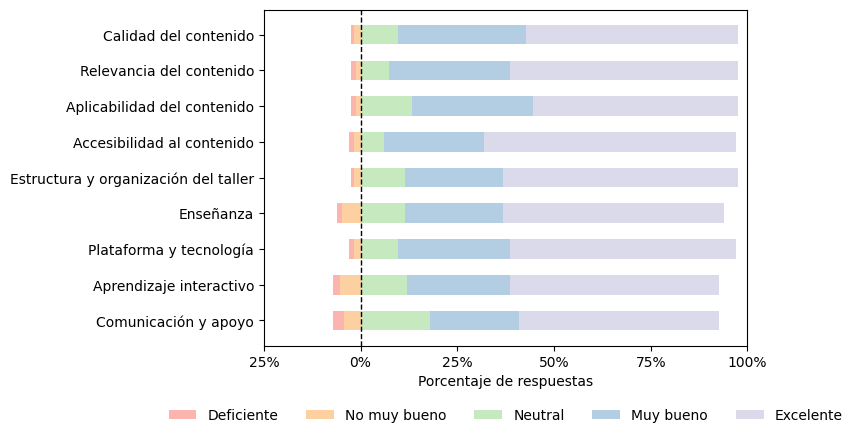

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- columnas y etiquetas ---
cols = ['p03','p04','p05','p06','p07','p08','p09','p10','p11']
labels = [
    'Calidad del contenido',
    'Relevancia del contenido',
    'Aplicabilidad del contenido',
    'Accesibilidad al contenido',
    'Estructura y organización del taller',
    'Enseñanza',
    'Plataforma y tecnología',
    'Aprendizaje interactivo',
    'Comunicación y apoyo'
]

# --- asegurar numérico ---
lik = df[cols].apply(pd.to_numeric, errors='coerce')

# --- porcentajes por ítem (1..5), excluyendo 6 = "No aplica" ---
p1_def, p2_nmb, p3_neu, p4_mb, p5_exc, ns = [], [], [], [], [], []
for c in cols:
    s = lik[c].copy().where(lik[c] != 6, np.nan)
    cnt = s.value_counts(dropna=True).reindex([1,2,3,4,5], fill_value=0)
    n = int(cnt.sum())
    ns.append(n)
    pct = (cnt / n * 100) if n > 0 else cnt.astype(float)
    p1_def.append(pct[1])
    p2_nmb.append(pct[2])
    p3_neu.append(pct[3])
    p4_mb.append(pct[4])
    p5_exc.append(pct[5])

p1_def = np.array(p1_def)
p2_nmb = np.array(p2_nmb)
p3_neu = np.array(p3_neu)
p4_mb  = np.array(p4_mb)
p5_exc = np.array(p5_exc)

# --- paleta pastel elegante ---
colors = {
    'Deficiente':   '#fbb4ae',   # rojo pastel
    'No muy bueno': '#fdd0a2',   # naranja pastel
    'Neutral':      '#c7e9c0',   # verde pastel
    'Muy bueno':    '#b3cde3',   # azul pastel
    'Excelente':    '#dadaeb'    # lila pastel
}

# --- gráfico tipo Likert divergente ---
fig, ax = plt.subplots(figsize=(8, 4.5))   # más compacto en ancho
y = np.arange(len(cols))
bar_height = 0.55   # grosor de las barras

# lado izquierdo (orden corregido: Deficiente más extremo, luego No muy bueno)
left_nmb = -p2_nmb
ax.barh(y, p2_nmb, left=left_nmb, color=colors['No muy bueno'], height=bar_height, label='No muy bueno')

left_def = -(p1_def + p2_nmb)
ax.barh(y, p1_def, left=left_def, color=colors['Deficiente'], height=bar_height, label='Deficiente')

# neutral
ax.barh(y, p3_neu, left=0, color=colors['Neutral'], height=bar_height, label='Neutral')

# lado positivo
ax.barh(y, p4_mb, left=p3_neu, color=colors['Muy bueno'], height=bar_height, label='Muy bueno')
ax.barh(y, p5_exc, left=p3_neu + p4_mb, color=colors['Excelente'], height=bar_height, label='Excelente')

# formato
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Porcentaje de respuestas')
ax.set_xlim(-25, 100)   # inicio en -25 para compactar
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.invert_yaxis()

# ticks con valores absolutos (sin signo en la izquierda)
ticks = np.arange(-25, 101, 25)
ax.set_xticks(ticks)
ax.set_xticklabels([f'{abs(t)}%' for t in ticks])

# leyenda ordenada y compacta
handles, leg_labels = ax.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]  # Deficiente queda más a la izquierda que No muy bueno
ax.legend([handles[i] for i in order],
          [leg_labels[i] for i in order],
          loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=5, frameon=False)

# ax.set_title('Análisis de ítems cerrados (escala Likert)', pad=15)
plt.tight_layout()
plt.show()

# (opcional) guardar en alta calidad
# plt.savefig("grafico_likert.png", dpi=300, bbox_inches="tight")
# plt.savefig("grafico_likert.pdf", bbox_inches="tight")


In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
options(repos='https://cloud.r-project.org')
if (!requireNamespace("polycor", quietly = TRUE)) install.packages("polycor")
if (!requireNamespace("psych", quietly = TRUE)) install.packages("psych")


In [10]:
%%R
library(polycor)
library(psych)
print("¡Paquetes cargados correctamente!")

[1] "¡Paquetes cargados correctamente!"



Attaching package: ‘psych’

The following object is masked from ‘package:polycor’:

    polyserial



In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
from rpy2.robjects import pandas2ri, r

pandas2ri.activate()

def _polychoric_corr_R(df_items: pd.DataFrame) -> pd.DataFrame:
    """
    Estima la matriz de correlaciones policóricas con R (polycor::hetcor).
    Aplica listwise deletion (filas completas). Silencia mensajes/warnings de R.
    """
    data = df_items.dropna(axis=0).copy()
    if data.shape[0] < 5:
        raise ValueError("Muy pocos casos tras eliminar NA.")
    r.assign("Xdf", pandas2ri.py2rpy(data.astype(float)))
    R_mat = r("""
        suppressMessages(suppressWarnings(library(polycor)))
        hc <- suppressMessages(suppressWarnings(hetcor(Xdf, ML=TRUE)))
        as.matrix(hc$correlations)
    """)
    R_np = np.array(R_mat, dtype=float)
    return pd.DataFrame(R_np, index=data.columns, columns=data.columns)

def ordinal_alpha_from_corr(R: pd.DataFrame) -> float:
    """
    Alfa de Cronbach calculado sobre una matriz de correlación.
    """
    k = R.shape[0]
    tr = np.trace(R.values)
    ssum = R.values.sum()
    return (k / (k - 1.0)) * (1.0 - (tr / ssum))

def ordinal_alpha_ci(df_items: pd.DataFrame, n_boot: int = 2000, seed: int = 42, progress: bool = True):
    """
    Alfa de Cronbach ORDINAL (policórico) + IC 95% (bootstrap de filas).
    Suprime warnings durante cada réplica para evitar spam en la salida.
    """
    rng = np.random.default_rng(seed)

    # Estimación puntual
    R0 = _polychoric_corr_R(df_items)
    alpha0 = ordinal_alpha_from_corr(R0)

    # Bootstrap
    data = df_items.dropna(axis=0).copy()
    alphas = []
    iterator = tqdm(range(n_boot), desc="Bootstrap (ordinal alpha)", ncols=80) if progress else range(n_boot)

    for _ in iterator:
        idx = rng.integers(0, data.shape[0], size=data.shape[0])
        sample = data.iloc[idx, :]
        try:
            # Silenciar warnings de Python durante la réplica
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                Rb = _polychoric_corr_R(sample)
            ab = ordinal_alpha_from_corr(Rb)
            if np.isfinite(ab):
                alphas.append(ab)
        except Exception:
            # Omitir réplicas problemáticas (convergencia, categorías vacías, etc.)
            continue

    alphas = np.asarray(alphas, dtype=float)
    if alphas.size < max(50, 0.5*n_boot):
        raise RuntimeError("Demasiadas fallas en el bootstrap policórico. Revisa tamaño muestral/categorías.")

    lo, hi = np.percentile(alphas, [2.5, 97.5])
    return {
        "alpha_ordinal": float(alpha0),
        "ci95": (float(lo), float(hi)),
        "n_boot_ok": int(alphas.size),
        "n_items": int(df_items.shape[1]),
        "n_obs": int(data.shape[0]),
    }


In [16]:
cols = ['p03','p04','p05','p06','p07','p08','p09','p10','p11']
df_items = df[cols].apply(pd.to_numeric, errors='coerce')

# Calcula alfa ordinal + IC 95%
results = ordinal_alpha_ci(df_items, n_boot=500, seed=42)
print(f"Alfa de Cronbach (ordinal): {results['alpha_ordinal']:.3f}")
print(f"IC 95%: [{results['ci95'][0]:.3f}, {results['ci95'][1]:.3f}]")
print(results)


Bootstrap (ordinal alpha): 100%|██████████████| 500/500 [02:06<00:00,  3.96it/s]

Alfa de Cronbach (ordinal): 0.957
IC 95%: [0.936, 0.970]
{'alpha_ordinal': 0.9566089234285949, 'ci95': (0.935984291309149, 0.9699732731856529), 'n_boot_ok': 500, 'n_items': 9, 'n_obs': 166}


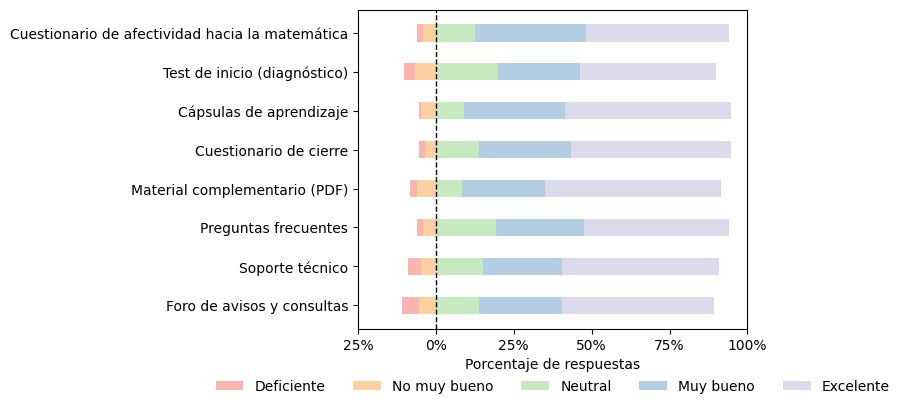

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1) Columnas p14–p21 (en ese orden) =====
cols = [f"p{n:02d}" for n in range(14, 22)]
cols = [c for c in cols if c in df.columns]
if len(cols) != 8:
    print("Aviso: se encontraron estas columnas:", cols)

# ===== 2) Etiquetas EXACTAS en el mismo orden =====
labels = [
    "Cuestionario de afectividad hacia la matemática",
    "Test de inicio (diagnóstico)",
    "Cápsulas de aprendizaje",
    "Cuestionario de cierre",
    "Material complementario (PDF)",
    "Preguntas frecuentes",
    "Soporte técnico",
    "Foro de avisos y consultas"
][:len(cols)]

# ===== 3) Asegurar numérico =====
lik = df[cols].apply(pd.to_numeric, errors='coerce')

# ===== 4) Porcentajes por categoría (1..5), excluyendo 6 = No aplica =====
p1_def, p2_nmb, p3_neu, p4_mb, p5_exc, ns = [], [], [], [], [], []
for c in cols:
    s = lik[c].copy().where(lik[c] != 6, np.nan)               # quita "No aplica"
    cnt = s.value_counts(dropna=True).reindex([1,2,3,4,5], fill_value=0)
    n = int(cnt.sum())
    ns.append(n)
    pct = (cnt / n * 100) if n > 0 else cnt.astype(float)
    p1_def.append(pct[1])   # 1 = Deficiente
    p2_nmb.append(pct[2])   # 2 = No muy bueno
    p3_neu.append(pct[3])   # 3 = Neutral
    p4_mb.append(pct[4])    # 4 = Muy bueno
    p5_exc.append(pct[5])   # 5 = Excelente

p1_def = np.array(p1_def); p2_nmb = np.array(p2_nmb)
p3_neu = np.array(p3_neu); p4_mb  = np.array(p4_mb); p5_exc = np.array(p5_exc)

# ===== 5) Paleta pastel elegante =====
colors = {
    'Deficiente':   '#fbb4ae',   # rojo pastel
    'No muy bueno': '#fdd0a2',   # naranja pastel
    'Neutral':      '#c7e9c0',   # verde pastel
    'Muy bueno':    '#b3cde3',   # azul pastel
    'Excelente':    '#dadaeb'    # lila pastel
}

# ===== 6) Gráfico Likert divergente (orden corregido a la izquierda) =====
fig_height = max(4.2, 0.38*len(cols))
fig, ax = plt.subplots(figsize=(8, fig_height))   # ancho compacto
y = np.arange(len(cols))
bar_height = 0.45

# Izquierda: No muy bueno pegado al 0, Deficiente más a la izquierda
left_nmb = -p2_nmb
ax.barh(y, p2_nmb, left=left_nmb, color=colors['No muy bueno'],
        height=bar_height, label='No muy bueno')

left_def = -(p1_def + p2_nmb)
ax.barh(y, p1_def, left=left_def, color=colors['Deficiente'],
        height=bar_height, label='Deficiente')

# Centro y derecha
ax.barh(y, p3_neu, left=0, color=colors['Neutral'],
        height=bar_height, label='Neutral')
ax.barh(y, p4_mb, left=p3_neu, color=colors['Muy bueno'],
        height=bar_height, label='Muy bueno')
ax.barh(y, p5_exc, left=p3_neu + p4_mb, color=colors['Excelente'],
        height=bar_height, label='Excelente')

# ===== 7) Formato =====
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Porcentaje de respuestas')
ax.set_xlim(-25, 100)                         # evita espacio en blanco a la izquierda
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.invert_yaxis()

# Ticks con valores absolutos (sin signo)
ticks = np.arange(-25, 101, 25)
ax.set_xticks(ticks)
ax.set_xticklabels([f'{abs(t)}%' for t in ticks])

# Leyenda en orden izquierda→derecha
handles, leg_labels = ax.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]  # Deficiente (más a la izq), No muy bueno, Neutral, Muy bueno, Excelente
ax.legend([handles[i] for i in order], [leg_labels[i] for i in order],
          loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=5, frameon=False)

# ax.set_title('Contribución de recursos al aprendizaje (escala Likert)', pad=10)

plt.tight_layout()
plt.show()

# (opcional) Guardar en alta calidad:
# plt.savefig("likert_p14_p21.png", dpi=300, bbox_inches="tight")
# plt.savefig("likert_p14_p21.pdf", bbox_inches="tight")


In [17]:
cols = [f"p{n:02d}" for n in range(14, 22)]
cols = [c for c in cols if c in df.columns]
df_items = df[cols].apply(pd.to_numeric, errors='coerce')

# Calcula alfa ordinal + IC 95%
results = ordinal_alpha_ci(df_items, n_boot=500, seed=42)
print(f"Alfa de Cronbach (ordinal): {results['alpha_ordinal']:.3f}")
print(f"IC 95%: [{results['ci95'][0]:.3f}, {results['ci95'][1]:.3f}]")
print(results)

Bootstrap (ordinal alpha): 100%|██████████████| 500/500 [01:43<00:00,  4.83it/s]

Alfa de Cronbach (ordinal): 0.937
IC 95%: [0.916, 0.953]
{'alpha_ordinal': 0.9373831163382157, 'ci95': (0.9163670644476815, 0.9532623800984014), 'n_boot_ok': 500, 'n_items': 8, 'n_obs': 166}


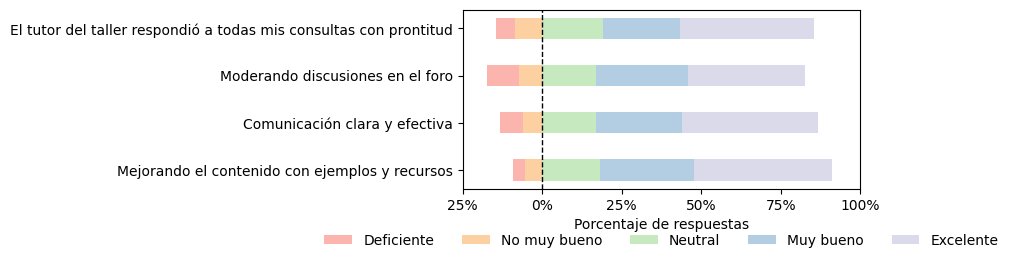

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1) Columnas p24–p27 (en ese orden) =====
cols = [f"p{n:02d}" for n in range(24, 28)]
cols = [c for c in cols if c in df.columns]
if len(cols) != 4:
    print("Aviso: se encontraron estas columnas:", cols)

# ===== 2) Etiquetas EXACTAS (mismo orden que la pregunta adjunta) =====
labels = [
    "El tutor del taller respondió a todas mis consultas con prontitud",
    "Moderando discusiones en el foro",
    "Comunicación clara y efectiva",
    "Mejorando el contenido con ejemplos y recursos"
][:len(cols)]

# ===== 3) Asegurar numérico =====
lik = df[cols].apply(pd.to_numeric, errors='coerce')

# ===== 4) Porcentajes por categoría (1..5), excluyendo 6 = No aplica =====
p1_def, p2_nmb, p3_neu, p4_mb, p5_exc, ns = [], [], [], [], [], []
for c in cols:
    s = lik[c].copy().where(lik[c] != 6, np.nan)               # quita "No aplica"
    cnt = s.value_counts(dropna=True).reindex([1,2,3,4,5], fill_value=0)
    n = int(cnt.sum())
    ns.append(n)
    pct = (cnt / n * 100) if n > 0 else cnt.astype(float)
    p1_def.append(pct[1])   # 1 = Deficiente
    p2_nmb.append(pct[2])   # 2 = No muy bueno
    p3_neu.append(pct[3])   # 3 = Neutral
    p4_mb.append(pct[4])    # 4 = Muy bueno
    p5_exc.append(pct[5])   # 5 = Excelente

p1_def = np.array(p1_def); p2_nmb = np.array(p2_nmb)
p3_neu = np.array(p3_neu); p4_mb  = np.array(p4_mb); p5_exc = np.array(p5_exc)

# ===== 5) Paleta pastel elegante =====
colors = {
    'Deficiente':   '#fbb4ae',   # rojo pastel
    'No muy bueno': '#fdd0a2',   # naranja pastel
    'Neutral':      '#c7e9c0',   # verde pastel
    'Muy bueno':    '#b3cde3',   # azul pastel
    'Excelente':    '#dadaeb'    # lila pastel
}

# ===== 6) Gráfico Likert divergente (orden correcto a la izquierda) =====
fig, ax = plt.subplots(figsize=(9, 2.8))   # ancho compacto; alto para 4 ítems
y = np.arange(len(cols))
bar_height = 0.45

# Izquierda: "No muy bueno" pegado al 0; "Deficiente" más a la izquierda
left_nmb = -p2_nmb
ax.barh(y, p2_nmb, left=left_nmb, color=colors['No muy bueno'],
        height=bar_height, label='No muy bueno')

left_def = -(p1_def + p2_nmb)
ax.barh(y, p1_def, left=left_def, color=colors['Deficiente'],
        height=bar_height, label='Deficiente')

# Centro y derecha
ax.barh(y, p3_neu, left=0, color=colors['Neutral'],
        height=bar_height, label='Neutral')
ax.barh(y, p4_mb, left=p3_neu, color=colors['Muy bueno'],
        height=bar_height, label='Muy bueno')
ax.barh(y, p5_exc, left=p3_neu + p4_mb, color=colors['Excelente'],
        height=bar_height, label='Excelente')

# ===== 7) Formato =====
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Porcentaje de respuestas')
ax.set_xlim(-25, 100)                       # evita espacio en blanco a la izquierda
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.invert_yaxis()

# Ticks como porcentajes positivos (sin signo a la izquierda)
ticks = np.arange(-25, 101, 25)
ax.set_xticks(ticks)
ax.set_xticklabels([f'{abs(t)}%' for t in ticks])

# Leyenda en orden izquierda→derecha
handles, leg_labels = ax.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]  # Deficiente, No muy bueno, Neutral, Muy bueno, Excelente
ax.legend([handles[i] for i in order], [leg_labels[i] for i in order],
          loc='upper center', bbox_to_anchor=(0.5, -0.18),
          ncol=5, frameon=False)

# ax.set_title('Evaluación del tutor del taller (escala Likert)', pad=10)

plt.tight_layout()
plt.show()

# (opcional) Guardar en alta calidad
# plt.savefig("likert_p24_p27.png", dpi=300, bbox_inches="tight")
# plt.savefig("likert_p24_p27.pdf", bbox_inches="tight")


In [18]:
cols = [f"p{n:02d}" for n in range(24, 28)]
cols = [c for c in cols if c in df.columns]
df_items = df[cols].apply(pd.to_numeric, errors='coerce')

# Calcula alfa ordinal + IC 95%
results = ordinal_alpha_ci(df_items, n_boot=500, seed=42)
print(f"Alfa de Cronbach (ordinal): {results['alpha_ordinal']:.3f}")
print(f"IC 95%: [{results['ci95'][0]:.3f}, {results['ci95'][1]:.3f}]")
print(results)

Bootstrap (ordinal alpha): 100%|██████████████| 500/500 [00:21<00:00, 23.48it/s]

Alfa de Cronbach (ordinal): 0.945
IC 95%: [0.924, 0.963]
{'alpha_ordinal': 0.9454114401522142, 'ci95': (0.9242444162190373, 0.9632990915278654), 'n_boot_ok': 500, 'n_items': 4, 'n_obs': 166}


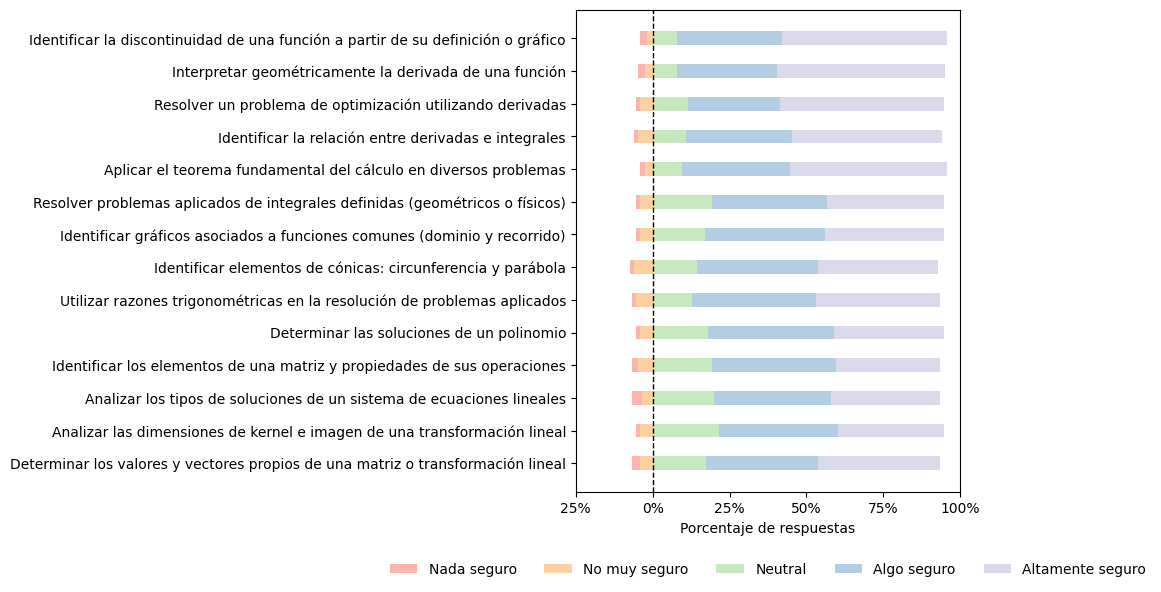

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1) Columnas p37–p50 (en ese orden) =====
cols = [f"p{n:02d}" for n in range(37, 51)]
cols = [c for c in cols if c in df.columns]
if len(cols) != 14:
    print("Aviso: columnas detectadas:", cols)

# ===== 2) Etiquetas EXACTAS en el mismo orden de la pregunta =====
labels = [
    "Identificar la discontinuidad de una función a partir de su definición o gráfico",
    "Interpretar geométricamente la derivada de una función",
    "Resolver un problema de optimización utilizando derivadas",
    "Identificar la relación entre derivadas e integrales",
    "Aplicar el teorema fundamental del cálculo en diversos problemas",
    "Resolver problemas aplicados de integrales definidas (geométricos o físicos)",
    "Identificar gráficos asociados a funciones comunes (dominio y recorrido)",
    "Identificar elementos de cónicas: circunferencia y parábola",
    "Utilizar razones trigonométricas en la resolución de problemas aplicados",
    "Determinar las soluciones de un polinomio",
    "Identificar los elementos de una matriz y propiedades de sus operaciones",
    "Analizar los tipos de soluciones de un sistema de ecuaciones lineales",
    "Analizar las dimensiones de kernel e imagen de una transformación lineal",
    "Determinar los valores y vectores propios de una matriz o transformación lineal"
][:len(cols)]

# ===== 3) Asegurar numérico =====
lik = df[cols].apply(pd.to_numeric, errors='coerce')

# ===== 4) Porcentajes por categoría (1..5), excluyendo 6 = No aplica =====
p1_nada, p2_poco, p3_neu, p4_algo, p5_alto, ns = [], [], [], [], [], []
for c in cols:
    s = lik[c].copy().where(lik[c] != 6, np.nan)   # elimina "No aplica"
    cnt = s.value_counts(dropna=True).reindex([1,2,3,4,5], fill_value=0)
    n = int(cnt.sum())
    ns.append(n)
    pct = (cnt / n * 100) if n > 0 else cnt.astype(float)
    p1_nada.append(pct[1])   # 1 = Nada seguro
    p2_poco.append(pct[2])   # 2 = No muy seguro
    p3_neu.append(pct[3])    # 3 = Neutral
    p4_algo.append(pct[4])   # 4 = Algo seguro
    p5_alto.append(pct[5])   # 5 = Altamente seguro

p1_nada = np.array(p1_nada); p2_poco = np.array(p2_poco)
p3_neu  = np.array(p3_neu);  p4_algo = np.array(p4_algo); p5_alto = np.array(p5_alto)

# ===== 5) Paleta pastel elegante =====
colors = {
    'Nada seguro':      '#fbb4ae',   # rojo pastel
    'No muy seguro':    '#fdd0a2',   # naranja pastel
    'Neutral':          '#c7e9c0',   # verde pastel
    'Algo seguro':      '#b3cde3',   # azul pastel
    'Altamente seguro': '#dadaeb'    # lila pastel
}

# ===== 6) Gráfico Likert divergente =====
fig_height = max(6, 0.38*len(cols))            # ajusta alto según nº de ítems
fig, ax = plt.subplots(figsize=(10, fig_height))  # ancho compacto
y = np.arange(len(cols))
bar_height = 0.42

# Lado izquierdo (cálculo con anchos positivos y offsets negativos):
# "No muy seguro" pegado al 0; "Nada seguro" más a la izquierda
left_poco = -p2_poco
ax.barh(y, p2_poco, left=left_poco, color=colors['No muy seguro'],
        height=bar_height, label='No muy seguro')

left_nada = -(p1_nada + p2_poco)
ax.barh(y, p1_nada, left=left_nada, color=colors['Nada seguro'],
        height=bar_height, label='Nada seguro')

# Centro y lado derecho
ax.barh(y, p3_neu,  left=0, color=colors['Neutral'],
        height=bar_height, label='Neutral')
ax.barh(y, p4_algo, left=p3_neu, color=colors['Algo seguro'],
        height=bar_height, label='Algo seguro')
ax.barh(y, p5_alto, left=p3_neu + p4_algo, color=colors['Altamente seguro'],
        height=bar_height, label='Altamente seguro')

# ===== 7) Formato =====
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Porcentaje de respuestas')
ax.set_xlim(-25, 100)                   # evita espacio en blanco a la izquierda
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.invert_yaxis()

# Ticks con valores absolutos (sin signo negativo)
ticks = np.arange(-25, 101, 25)
ax.set_xticks(ticks)
ax.set_xticklabels([f'{abs(t)}%' for t in ticks])

# Leyenda ordenada de izquierda→derecha
handles, leg_labels = ax.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]  # Nada seguro, No muy seguro, Neutral, Algo seguro, Altamente seguro
ax.legend([handles[i] for i in order], [leg_labels[i] for i in order],
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=5, frameon=False)

# ax.set_title('Confianza para realizar resultados de aprendizaje (escala Likert)', pad=10)

plt.tight_layout()
plt.show()

# (opcional) Guardar en alta calidad:
# plt.savefig("likert_p37_p50.png", dpi=300, bbox_inches="tight")
# plt.savefig("likert_p37_p50.pdf", bbox_inches="tight")


In [19]:
cols = [f"p{n:02d}" for n in range(37, 51)]
cols = [c for c in cols if c in df.columns]
df_items = df[cols].apply(pd.to_numeric, errors='coerce')

# Calcula alfa ordinal + IC 95%
results = ordinal_alpha_ci(df_items, n_boot=500, seed=42)
print(f"Alfa de Cronbach (ordinal): {results['alpha_ordinal']:.3f}")
print(f"IC 95%: [{results['ci95'][0]:.3f}, {results['ci95'][1]:.3f}]")
print(results)

Bootstrap (ordinal alpha): 100%|██████████████| 500/500 [04:33<00:00,  1.83it/s]

Alfa de Cronbach (ordinal): 0.977
IC 95%: [0.969, 0.984]
{'alpha_ordinal': 0.976988218739234, 'ci95': (0.9692254445669318, 0.9835040429877361), 'n_boot_ok': 500, 'n_items': 14, 'n_obs': 166}


# Análisis de respuestas abiertas estudiantes

In [ ]:
#@title <b><font color="blue" size="+2"> Pegamos la api_key de openai

clave_api = '[INSERT YOU API KEY]'  #@param {type: "string"}


In [13]:
# !pip install openai
# !pip install annoy
# !pip install PyPDF2
from annoy import AnnoyIndex
import openai
from openai import OpenAI
import os
import pandas as pd
import PyPDF2
import pprint

## 1. Generar embeddings de las respuestas
Los embeddings convierten cada respuesta en un vector numérico, lo que nos permite medir similitud y agrupar.

In [26]:
from openai import OpenAI
import pandas as pd
import numpy as np # Import numpy for NaN handling

client = OpenAI(api_key=clave_api)

# Pregunta a analizar
pxx = "p28"

# Generar embeddings
def obtener_embedding(texto):
    # Ensure the input is a string and handle potential NaN values
    if pd.isna(texto):
        texto = ""
    resp = client.embeddings.create(
        model="text-embedding-3-small",
        input=texto
    )
    return resp.data[0].embedding

# Handle NaN values in 'pxx' before applying the function
df[pxx] = df[pxx].replace(np.nan, "")

df["embedding"] = df[pxx].apply(obtener_embedding)

## 2. Hacer clustering con KMeans
Agrupamos opiniones similares en clusters.

Embeddings: 100%|██████████| 97/97 [00:26<00:00,  3.61it/s]



K óptimo seleccionado: 5
Silhouette(K óptimo): 0.0787
Resumen por K:
{'k': 2, 'inercia': 21.12669563293457, 'silhouette': 0.0748685747385025, 'tamaño_min_ok': np.True_}
{'k': 3, 'inercia': 19.60794448852539, 'silhouette': 0.07264166325330734, 'tamaño_min_ok': np.True_}
{'k': 4, 'inercia': 18.65520668029785, 'silhouette': 0.07576737552881241, 'tamaño_min_ok': np.True_}
{'k': 5, 'inercia': 17.818368911743164, 'silhouette': 0.07874761521816254, 'tamaño_min_ok': np.True_}
{'k': 6, 'inercia': 16.975082397460938, 'silhouette': 0.046018511056900024, 'tamaño_min_ok': np.False_}
{'k': 7, 'inercia': 16.238245010375977, 'silhouette': 0.04717658832669258, 'tamaño_min_ok': np.True_}
{'k': 8, 'inercia': 15.480916023254395, 'silhouette': 0.05261283367872238, 'tamaño_min_ok': np.False_}
{'k': 9, 'inercia': 14.680377960205078, 'silhouette': 0.05002512410283089, 'tamaño_min_ok': np.False_}
{'k': 10, 'inercia': 13.866768836975098, 'silhouette': 0.05637319013476372, 'tamaño_min_ok': np.False_}


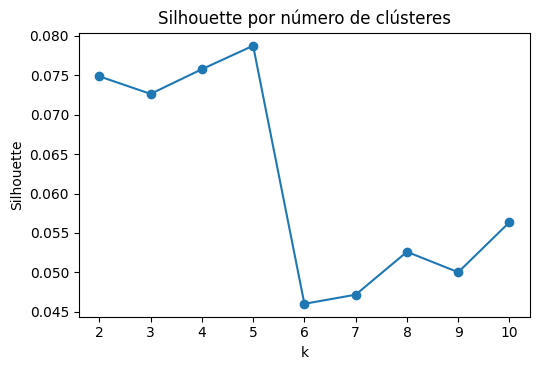

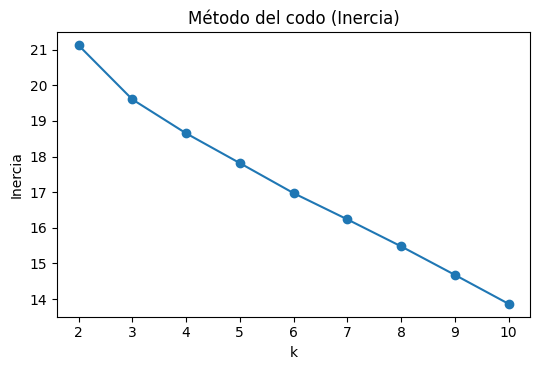

Términos top por clúster:
Cluster 0: tutor, tuve, taller, tutor taller, experiencia, interaccion tutor, tuve interaccion, interaccion, tuve relacion, relacion tutor
Cluster 1: explica, bien, bueno, bueno explicando, explicando, encontre bueno, manera, metodica, manera metodica, explica manera
Cluster 2: responder, siempre, consultas, mucho prefiero, prefiero, prefiero responder, agrado, agrado mucho, parece, parece disposicion
Cluster 3: comunicacion, tuve, tuve comunicacion, comunicacion necesario, nadie, contacto, tuve contacto, contacto nadie, tanta interaccion, tanta
Cluster 4: basta, sobra, basta sobra, revision basta, revision, ideal entregue, ideal, seria ideal, seria, entregue ejemplos

Cluster 0 (muestras):
      contenido del taller metodologico y practico
fue muy poco el uso de la plataforma por mi par...
                            tuve mayor experiencia
             tuve relación con el tutor del taller
               fue buena experiencia de aprndizaje

Cluster 1 (muestra

In [27]:
# ============================================
# Clustering de respuestas en df["pxx"] SIN encabezados vacíos
# ============================================

# --- Dependencias
from openai import OpenAI
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Pregunta a analizar
pxx = "p28"

# --- Config OpenAI
client = OpenAI(api_key=clave_api)

# --- Stopwords ES (base + dominio educativo)
SPANISH_STOPWORDS = {
    # comunes
    "a","acá","ahí","al","algo","algunas","algunos","allá","allí","ambos","ante","antes","aquel",
    "aquella","aquellas","aquello","aquellos","aquí","así","aún","aun","aunque","cada","casi","como",
    "con","contra","cual","cuales","cuando","cuanta","cuantas","cuanto","cuantos","de","del","desde",
    "donde","dos","el","él","ella","ellas","ellos","en","entre","era","erais","eran","eras","eres",
    "es","esa","esas","ese","eso","esos","esta","estaba","estabais","estaban","estabas","estad",
    "estada","estadas","estado","estados","estamos","están","estar","estará","estarán","estaré",
    "estaría","estas","este","esto","estos","estoy","fin","fue","fueron","fui","fuimos","ha","habéis",
    "haber","había","habían","habías","han","has","hasta","hay","haya","he","hemos","hoy","la","las",
    "le","les","lo","los","mas","más","me","mi","mis","mientras","muy","nada","ni","no","nos",
    "nosotras","nosotros","nuestra","nuestras","nuestro","nuestros","o","os","otra","otras","otro",
    "otros","para","pero","poco","por","porque","que","qué","quien","quién","quienes","se","ser","si",
    "sí","sin","sobre","sois","somos","son","soy","su","sus","tal","también","tanto","te","ti","tiene",
    "tienen","toda","todas","todavía","todo","todos","tu","tus","un","una","uno","unos","usted",
    "ustedes","ya","yo",
    # educativo / ruido
    "curso","nivelación","universidad","udla","imfe","clase","clases","profe","profesor","profesora",
    "docente","estudiante","estudiantes","contenido","contenidos","módulo","módulos","tema","temas",
    "aprendizaje","aprendizajes","evaluación","evaluaciones","ayuda","actividad","actividades",
    "semana","semanas",pxx,"video","videos", "br", "y", "nbsp"
}

# -------------------------------
# 1) Limpieza básica de df[pxx]
# -------------------------------
df = df.copy()
df[pxx] = (
    df[pxx]
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)
df[pxx] = df[pxx].replace({"nan": ""})  # evita strings "nan"
mask_nonempty = df[pxx].str.len() > 0
df["_is_empty"] = ~mask_nonempty

# -------------------------------
# 2) Embeddings (con caché)
# -------------------------------
_cache = {}
def obtener_embedding(texto: str):
    if not texto:
        return None
    if texto in _cache:
        return _cache[texto]
    resp = client.embeddings.create(model="text-embedding-3-small", input=texto)
    emb = resp.data[0].embedding
    _cache[texto] = emb
    return emb

tqdm.pandas(desc="Embeddings")
df.loc[mask_nonempty, "embedding"] = df.loc[mask_nonempty, pxx].progress_apply(obtener_embedding)

# ------------------------------------
# 3) Filtro de textos muy cortos
# ------------------------------------
def limpiar_basico(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^\wáéíóúñü\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokens_sin_stop(s: str, stopset):
    toks = limpiar_basico(s).split()
    return [t for t in toks if t not in stopset]

# Al menos 3 tokens de contenido (tras stopwords)
mask_util = df[pxx].apply(lambda x: len(tokens_sin_stop(str(x), SPANISH_STOPWORDS)) >= 3)
df["_usable"] = mask_util & df["embedding"].notna()

# Subconjunto REAL para clusterizar (de aquí en adelante se imprimen muestras)
df_emb = df.loc[df["_usable"]].copy()

# ============================================
# 4) Selección de K óptimo + Clustering KMeans
# ============================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

def _elbow_by_distance(ks, inertias):
    """
    El 'codo' se define como el punto con mayor distancia perpendicular
    a la recta entre (k_min, inertia_min) y (k_max, inertia_max).
    """
    ks = np.asarray(ks, dtype=float)
    ys = np.asarray(inertias, dtype=float)
    x = (ks - ks.min()) / (ks.max() - ks.min() + 1e-12)
    y = (ys - ys.min()) / (ys.max() - ys.min() + 1e-12)
    p1 = np.array([x[0], y[0]])
    p2 = np.array([x[-1], y[-1]])
    v = p2 - p1
    v /= (np.linalg.norm(v) + 1e-12)
    dists = []
    for xi, yi in zip(x, y):
        p = np.array([xi, yi])
        proj_len = np.dot(p - p1, v)
        proj = p1 + proj_len * v
        dists.append(np.linalg.norm(p - proj))
    return int(ks[int(np.argmax(dists))])

def seleccionar_k_optimo(
    X,
    k_min=2,
    k_max=10,
    min_size=3,
    n_init=20,
    random_state=42,
    use_elbow_fallback=True
):
    """
    Devuelve: k_opt, modelo_kmeans, labels, diagnosticos(dict)
    - Elige el k con mayor silhouette entre los que cumplen tamaño mínimo.
    - Si no hay silhouette válido, usa Elbow como respaldo.
    """
    ks = list(range(k_min, min(k_max, len(X)) + 1))
    resultados = []  # [(k, inertia, silhouette, sizes_ok, labels, model)]

    for k in ks:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        labels = km.fit_predict(X)
        sizes = np.bincount(labels, minlength=k)
        sizes_ok = (sizes > 0).all() and (sizes >= min_size).all()
        inertia = float(km.inertia_)
        sil = None
        if len(np.unique(labels)) > 1:
            try:
                sil = float(silhouette_score(X, labels))
            except Exception:
                sil = None
        resultados.append((k, inertia, sil, sizes_ok, labels, km))

    # 1) Silhouette máximo entre los que cumplen tamaño mínimo
    candidatos = [(k, sil, km, lbl) for (k, _, sil, ok, lbl, km) in resultados if ok and sil is not None]
    if candidatos:
        # si empatan en silhouette, elegir el menor k (parsimonioso)
        k_opt, sil_opt, km_opt, labels_opt = sorted(candidatos, key=lambda t: (-t[1], t[0]))[0]
    else:
        # 2) Relajar tamaño mínimo y usar silhouette
        relajados = [(k, sil, km, lbl) for (k, _, sil, _ok, lbl, km) in resultados if sil is not None]
        if relajados:
            k_opt, sil_opt, km_opt, labels_opt = sorted(relajados, key=lambda t: (-t[1], t[0]))[0]
        else:
            # 3) Respaldo: Elbow por inercia
            if use_elbow_fallback:
                ks_all = [k for (k, *_rest) in resultados]
                inertias_all = [inertia for (_k, inertia, *_rest) in resultados]
                k_opt = _elbow_by_distance(ks_all, inertias_all)
                km_opt = KMeans(n_clusters=k_opt, n_init=n_init, random_state=random_state).fit(X)
                labels_opt = km_opt.labels_
                sil_opt = silhouette_score(X, labels_opt) if len(np.unique(labels_opt)) > 1 else None
            else:
                # último recurso: el primer k
                k_opt, sil_opt, km_opt, labels_opt = resultados[0][0], resultados[0][2], resultados[0][5], resultados[0][4]

    diag = {
        "tabla": [
            {"k": k, "inercia": inertia, "silhouette": sil, "tamaño_min_ok": ok}
            for (k, inertia, sil, ok, *_rest) in resultados
        ],
        "k_opt": k_opt,
        "silhouette_k_opt": sil_opt
    }
    return k_opt, km_opt, labels_opt, diag

# ======================
# Ejecutar clustering
# ======================
if len(df_emb) < 3:
    # Datos insuficientes
    df_emb["cluster"] = 0
    df["cluster"] = np.where(df["_usable"], 0, -1)
else:
    # Matriz de embeddings normalizada
    X = np.vstack(df_emb["embedding"].values).astype(np.float32)
    X = normalize(X, norm="l2", axis=1)

    # Selección de K óptimo
    k_opt, km_model, labels, diag = seleccionar_k_optimo(
        X,
        k_min=2,
        k_max=min(10, len(df_emb)),
        min_size=3,          # cambia si quieres clústeres más grandes
        n_init=20,
        random_state=42
    )

    print(f"\nK óptimo seleccionado: {k_opt}")
    print(f"Silhouette(K óptimo): {diag['silhouette_k_opt']:.4f}" if diag['silhouette_k_opt'] is not None else "Silhouette no disponible")
    print("Resumen por K:")
    for fila in diag["tabla"]:
        print(fila)

    # Etiquetas al subconjunto utilizable
    df_emb["cluster"] = labels

    # Re-etiquetar por tamaño descendente (0 = clúster más grande)
    uniq, counts = np.unique(labels, return_counts=True)
    orden = uniq[np.argsort(-counts)]
    remap = {old: i for i, old in enumerate(orden)}
    df_emb["cluster"] = np.vectorize(remap.get)(df_emb["cluster"].values)

    # Unir al df completo (no-usables = -1)
    df = df.join(df_emb["cluster"], how="left", rsuffix="_k")
    df["cluster"] = df["cluster"].fillna(-1).astype(int)

# ============================
# (Opcional) Curvas diagnósticas
# ============================
try:
    ks_plot = [r["k"] for r in diag["tabla"]]
    sils    = [r["silhouette"] for r in diag["tabla"]]
    inert   = [r["inercia"] for r in diag["tabla"]]

    plt.figure(figsize=(5.5,3.8))
    plt.plot(ks_plot, sils, marker='o')
    plt.title("Silhouette por número de clústeres")
    plt.xlabel("k"); plt.ylabel("Silhouette"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.5,3.8))
    plt.plot(ks_plot, inert, marker='o')
    plt.title("Método del codo (Inercia)")
    plt.xlabel("k"); plt.ylabel("Inercia"); plt.tight_layout(); plt.show()
except Exception:
    pass

# ------------------------------------
# 5) Interpretabilidad: TF-IDF por clúster (sobre df_emb, sin tildes)
# ------------------------------------
import unicodedata

def _sin_tildes(s: str) -> str:
    s = s.lower()
    return ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))

STOP_ES_NORMALIZADAS = {_sin_tildes(w) for w in SPANISH_STOPWORDS}

if not df_emb.empty:
    vectorizer = TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",       # consistente con las stopwords sin tildes
        stop_words=list(STOP_ES_NORMALIZADAS),
        max_features=5000,
        ngram_range=(1,2),
        token_pattern=r'(?u)\b\w+\b'
    )
    Tf = vectorizer.fit_transform(df_emb[pxx].astype(str).tolist())
    terms = np.array(vectorizer.get_feature_names_out())

    print("Términos top por clúster:")
    for c in sorted(df_emb["cluster"].unique().tolist()):
        idx = np.where(df_emb["cluster"].values == c)[0]
        if len(idx) == 0:
            continue
        mean_vec = Tf[idx].mean(axis=0).A1
        top_idx = mean_vec.argsort()[::-1][:10]
        print(f"Cluster {c}: {', '.join(terms[top_idx])}")

# ============================================
# 6) Muestras por clúster (igual que antes)
# ============================================
for c in sorted(df_emb["cluster"].unique().tolist()):
    # Changed from pxx
    muestras = df_emb.loc[df_emb["cluster"] == c, pxx].head(5)
    if len(muestras) == 0:
        continue
    print(f"\nCluster {c} (muestras):")
    print(muestras.to_string(index=False))

sizes_report = df_emb.groupby("cluster").size().rename("n").sort_index()
print("\nTamaño de clústeres:\n", sizes_report)

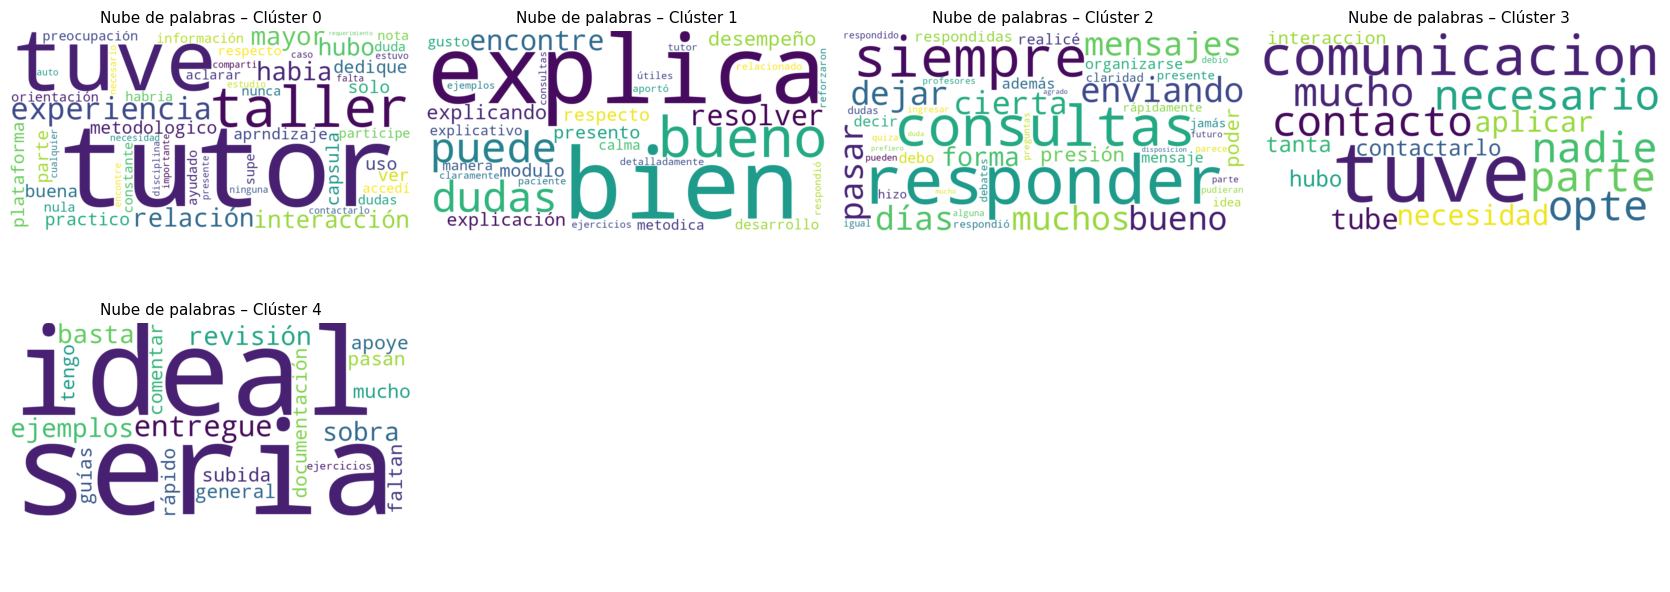

In [28]:
import math
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# pxx debe ser el nombre de la columna con texto (por ej., 'p64')
# pxx = 'p64'

def _tokens_sin_stop(s: str, stopset):
    s = s.lower()
    s = re.sub(r"[^\wáéíóúñü\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return [t for t in s.split() if t and t not in stopset]

clusters = sorted(df_emb["cluster"].unique().tolist())
n = len(clusters)
if n == 0:
    print("No hay clústeres para graficar.")
else:
    ncols = 4
    nrows = math.ceil(n / ncols)

    # tamaño proporcional: ancho ~ 4.2 por col, alto ~ 3.2 por fila
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.2*nrows))
    # normalizar axes a 2D
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = np.array([[ax] for ax in axes])

    idx = 0
    for r in range(nrows):
        for c in range(ncols):
            ax = axes[r, c]
            if idx >= n:
                ax.axis("off")
                continue

            cl = clusters[idx]
            textos = df_emb.loc[df_emb["cluster"] == cl, pxx].dropna().astype(str).tolist()

            # tokens y frecuencias (más estable que generate() con poco texto)
            toks = []
            for t in textos:
                toks.extend(_tokens_sin_stop(t, SPANISH_STOPWORDS))
            freq = Counter(toks)

            if len(freq) == 0:
                ax.axis("off")
                ax.set_title(f"Clúster {cl} (sin texto útil)", fontsize=10)
            else:
                wc = WordCloud(
                    width=1000, height=500,
                    background_color="white",
                    collocations=False, normalize_plurals=True,
                    stopwords=SPANISH_STOPWORDS,
                    random_state=42, max_words=150
                ).generate_from_frequencies(freq)
                ax.imshow(wc, interpolation="bilinear")
                ax.axis("off")
                ax.set_title(f"Nube de palabras – Clúster {cl}", fontsize=11)

            idx += 1

    plt.tight_layout()
    plt.show()

# Limpieza auxiliar (si aplica en tu flujo)
df.drop(columns=["_is_empty", "_usable"], inplace=True, errors="ignore")


In [29]:
import random

def describir_cluster(textos, max_ejemplos=20):
    if not textos:
        return "(sin datos en este clúster)"
    # Muestra representativa y compacta
    muestras = random.sample(textos, min(len(textos), max_ejemplos))
    bullets = "\n".join(f"- {t}" for t in muestras if isinstance(t, str) and t.strip())

    prompt = (
        "Estas son respuestas de estudiantes (muestra representativa):\n"
        f"{bullets}\n\n"
        "La pregunta fue: «Por favor, comparte más detalles sobre tu experiencia con el tutor del taller.»\n"
        "Propón un NOMBRE breve para el clúster y descríbelo en ≤20 palabras, "
        "concretamente y con pertinencia temática."
    )

    try:
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
        )
        return resp.choices[0].message.content.strip()
    except Exception as e:
        return f"(error al describir clúster: {e})"

# Recorre SOLO los clústeres presentes (excluye -1 si lo usas para “no usable”)
clusters_presentes = sorted([c for c in df['cluster'].unique() if c != -1])

for c in clusters_presentes:
    textos = df.loc[df["cluster"] == c, pxx].dropna().astype(str).tolist()
    descripcion = describir_cluster(textos, max_ejemplos=20)
    print(f"\nCluster {c}:\n{descripcion}")



Cluster 0:
**Nombre del clúster:** Interacción con el Tutor

**Descripción:** Variedad de experiencias con el tutor, desde apoyo constante hasta falta de información y contacto limitado.

Cluster 1:
**Nombre del clúster:** Eficacia en la Enseñanza

**Descripción:** Los estudiantes destacan la claridad, paciencia y metodología del tutor en sus explicaciones y resolución de dudas.

Cluster 2:
**Nombre del clúster:** **Comunicación y Apoyo del Tutor**

**Descripción:** Los estudiantes valoran la disponibilidad y rapidez en las respuestas del tutor, aunque algunos sienten falta de interacción.

Cluster 3:
**Nombre del clúster:** Comunicación limitada

**Descripción:** Los estudiantes experimentaron poca interacción y necesidad de contacto con el tutor durante el taller.

Cluster 4:
**Nombre del clúster:** Mejora de Recursos

**Descripción:** Los estudiantes solicitan más documentación, ejemplos y guías para optimizar su aprendizaje en el taller.
